# Tarea 4

* Sofía Cruz T. (**@cutsof**)
* Daniel Martínez U. (**@danmarurr**)

**Envío del PR inicial:** lunes 26 de septiembre

**Aceptación del PR:** lunes 10 de octubre

In [2]:
#Primero: cargamos toda la paquetería que usaremos
# Usaremos PyPlot ya que al parecer Julia 0.5 tiene problemas con Plots
using PyPlot, LsqFit, Roots,Polynomials
include("AutomDiff_V2.jl")
import AD: Dual, xdual


  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31


**Ejercicio 0:** Velocidad de convergencia

El objetivo de este ejercicio es relacionar, la velocidad de convergencia con que un punto fijo (o una órbita periódica, en el caso de los dos últimos incisos) atraen a puntos suficientemente cercanos, con la derivada del mapeo en el punto fijo (o ciclo periódico). La idea es, entonces, calcular primero el punto fijo y, después, medir cómo la distancia de los iterados sucesivos (de una condición inicial $x_0$) al punto fijo se comporta en el tiempo, para los siguientes mapeos:

- $F(x) = x^2+0.25$

- $F(x) = 3x(1-x)$

- $F(x) = \exp(x-1)$

- $F(x) = x^2 - 1.25$

- $F(x) = \exp(x+1)$

  Deberán resolver algunas cosas intermedias. Por ejemplo, ¿qué tanto deben acercarse al punto fijo, a fin de evitar ruido numérico? ¿Qué hay que hacer en el caso en que el punto sea neutral (ni atractivo ni repulsivo)?

  En los dos últimos incisos, el interés es en los ciclos de periodo 2.

### Solución

Para cada $F(x)$ encontraremos los puntos fijos correspondientes usando la paquetería `roots`, posteriormente averiguaremos que tanto debemos que tanto debemos acercarnos al punto fijo

In [2]:
#Definimos las funciones que emplearemos
F1(x) = x^2 + 0.25
F2(x) = 3x*(1 - x)
F3(x) = exp(x - 1)
F4(x) = x^2 - 0.25
F5(x) = exp(x + 1)

#Ahora implementareos una función que calcule los puntos fijos de una determinada F(x)

function puntofijo(F::Function, ran)
    rf = fzeros(x -> (F(x) - x) , ran)
    return rf
end

#Implementamos el método de Newton para buscar los ceros

function newton1D{T<:Real}(f::Function, adiv::T, tol = 1e-20)
    x0 = xdual(adiv)
    fx = f(x0)
    count = 0
    while abs(fx.fun) > tol
        count += 1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
    end
    return x0.fun
end

"""
`quadratic(a, b, c)` es una función `type-stable` que resuelve una ecuación de segundo grado con coeficientes 
reales: donde `a`es el coeficiente cuadrático, `b` el coeficiente lineal y `c` el coeficiente independiente, dado
a que el algoritmo emplea la función `sqrt` (que en general devuelve un valor del tipo `Float64` si el argumento de 
dicha función es un número `Real` se requiere que los argumentos `a`, `b` y `c` sean del tipo `Float64`
"""
function quadratic{T<:Real}(a::T, b::T, c::T)
    disc = b^2 - 4*a*c #Calculamos el valor del discriminante
    @assert a != 0 "Tu ecuación no es de segundo grado, revisa los argumentos.", disc < 0 
    "La ecuación tiene soluciones complejas, no es posible resolver la ecuación."
    resuelve_cuad(a,b,c, disc)
end

function resuelve_cuad(a, b, c, disc) #El algoritmo para encontrar las raíces
    sq = sqrt(disc)
    x1 = (-b+sq)/(2a)
    x2 = (-b-sq)/(2a)
    if x1 == x2
        raices = Float64[x1]
    else
        raices = typeof(x1)[x1,x2]
    end
    return raices
end

Para las funciones $F_1$ y $F_2$ podemos calcular los puntos fijos de forma sencilla usando la fórmula general, pues son polinomios de segundo grado:

In [4]:
r1 = quadratic(1.0, -1.0, 0.25)

1-element Array{Float64,1}:
 0.5

In [4]:
r2 = quadratic(-3.0, 2.0, 0.0)

2-element Array{Float64,1}:
 -0.0     
  0.666667

Para $F_3$ es claro que el único punto fijo es $x_3 = 1$. Ahora, para $F_4$ sabemos que los puntos fijos de orden también lo son de orden 2, entonces de $F4^2(x) -x$, descartaremos las raíces que se obtengan de $F4(x) -x$

In [ ]:
#Punto fijo de F3

r3 = Float64[puntofijo(x -> F3, -3)]

ERROR (unhandled task failure): MethodError: no method matching show_backtrace(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::Symbol, ::Array{Ptr{Void},1}, ::UnitRange{Int64})
Closest candidates are:
  show_backtrace(::IO, !Matched::Array{Any,1}) at replutil.jl:578
  show_backtrace(::IO, !Matched::Array{T,1}) at replutil.jl:572


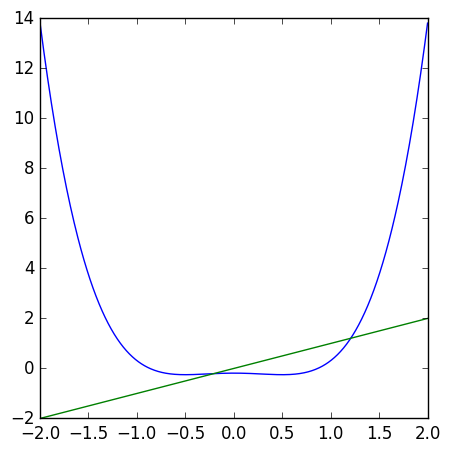

In [6]:
figure(figsize =(5,5))
ran1 = -2:1/128:2
m1 = map(x -> F4(F4(x)), ran1)
plot(ran1, m1)
plot(ran1, ran1)

show()

Pero $F4^2(x) -x$ sólo tiene dos raíces reales (según la gráfica, por lo que las otras dos deben ser complejas), entonces nos quedamos con éstos valores

In [7]:
r4 = quadratic(1.0, -1.0, -0.25)

2-element Array{Float64,1}:
  1.20711 
 -0.207107

In [14]:
#Ahora definamos una función que dado un x0 calcule la distancia entre las iteraciones y los puntos fijos
function sensibility{T<:Real}(F::Function, x0::T, pfijos::Array{Float64,1}, n = 1000)
    ℓ = length(pfijos)
    distancia = zeros(Float64, n, ℓ)
    for j in 1:ℓ
        pf = pfijos[j]
        it = copy(x0)
        for i in 1:n
            it = F(it)
            #@show it
            distancia[i, j] = abs(it - pf)
        end
    end
    return distancia
end
    

sensibility (generic function with 3 methods)

### Para $F_1$

Dado a que $F'_1(0.5) = 1$ tenemos que el punto fijo no es atractor ni repulsor, pero intuitivamente podríamos probar con valores $x_0$ tales que $F'_1(x_0) < 1$, con $x_0$ cercano a 0.5 para observar un comportamiento atractor:

In [9]:
pf1 = xdual(0.5)
F1(pf1)

AD.Dual{Float64}(0.5,1.0)

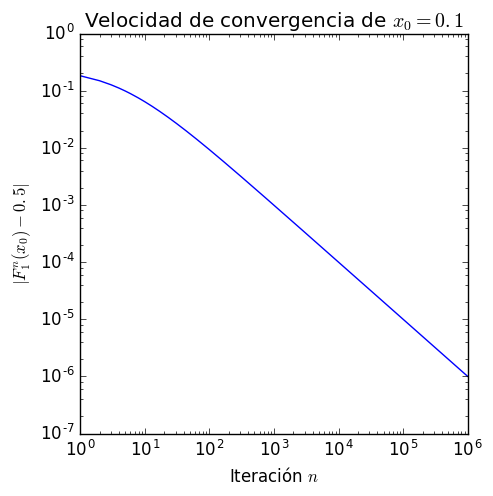

In [10]:
#Probemos primero con un punto x0 < 0.5
figure(figsize = (5, 5))
gr1 = sensibility(F1, 0.1, r1, 1000000);
d1 = reshape(gr1, 1000000)
loglog(d1)
title(L"Velocidad de convergencia de $x_0 = 0.1$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

Para calcular la velocidad de convergencia, podemos hacer una regresión lineal con los logarítmos de los datos que tenemos:

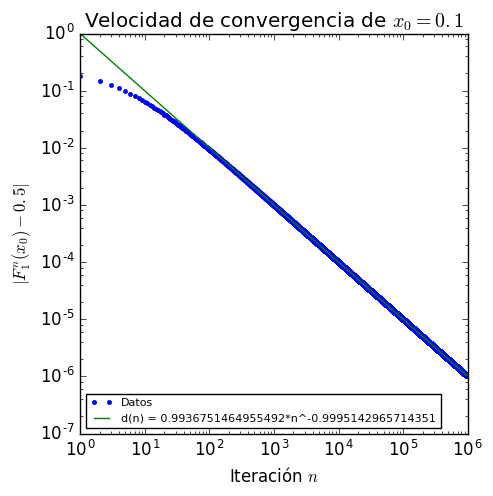

In [11]:
figure(figsize = (5,5))
dom1 = collect(1:1000000)
a1, b1 = linreg(log(dom1), log(d1))
ran1 = Float64[exp(a1)*x^b1 for x in dom1]
loglog(d1, ".", label = "Datos")
loglog(dom1, ran1, label = "d(n) = $(exp(a1))*n^$b1")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.1$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

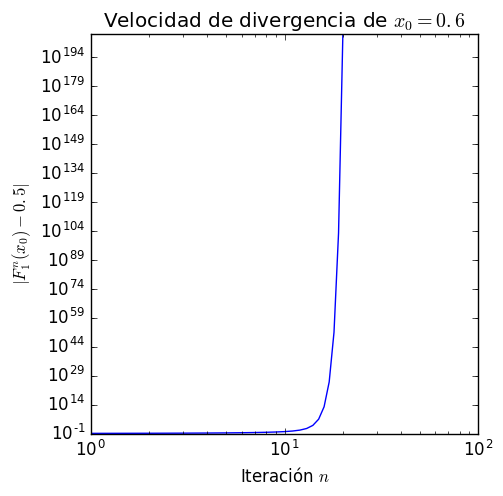

In [12]:
#Probemos ahora con un punto x0 > 0.5, para corroborar que para este valor, el punto fijo tiene comportamiento
#repulsor
figure(figsize = (5, 5))
gr1 = sensibility(F1, 0.6, r1, 100);
loglog(reshape(gr1, 100))
title(L"Velocidad de divergencia de $x_0 = 0.6$")
xlabel(L"Iteración $n$")
ylabel(L"|F_1^n(x_0) - 0.5|")
show()

### Para $F_2$

In [13]:
der2 = Float64[]

for j in r2
    x0 = xdual(j)
    push!(der2, F2(x0).der)
end
der2, r2

([3.0,-1.0],[-0.0,0.666667])

Para $F2$ tenemos que uno de los puntos fijos es repulsor y el otro atractor, tratemos con dos valores cercanos a $-1$ por la derecha y por la izquierda

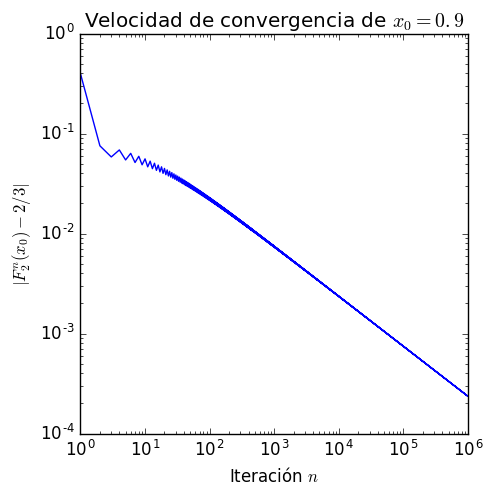

In [14]:
figure(figsize = (5, 5))
gr1 = sensibility(F2, 0.9, r2, 1000000)
d2 = reshape(gr1[:,2],1000000)
dom2 = collect(1:1000000)
loglog(dom2, d2)


title(L"Velocidad de convergencia de $x_0 = 0.9$")
xlabel(L"Iteración $n$")
ylabel(L"|F_2^n(x_0) - 2/3|")
show()

In [15]:
exp(a2)*dom2[end]^b2

LoadError: LoadError: UndefVarError: a2 not defined
while loading In[15], in expression starting on line 1

In [16]:
d2[end]

0.00023578256289147337

In [17]:
#Modelo para el ajuste de datos
model1(x, p) = p[1]*x + p[2]

model1 (generic function with 1 method)

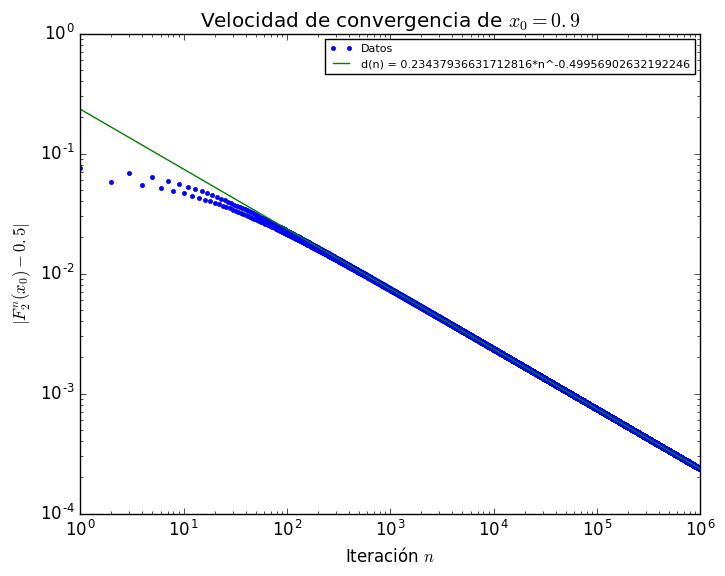

In [18]:
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2]
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "d(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.9$")
xlabel(L"Iteración $n$")
ylabel(L"|F_2^n(x_0) - 0.5|")
show()

### Para $F_3$

Dado a que $F'_3(1) = 1$ tendremos que proceder de la misma forma que en $F_1$:

In [19]:
figure(figsize = (5, 5))
gr1 = sensibility(F3, 0.9, r3, 1000000)
d2 = reshape(gr1[:,1],1000000)
dom2 = collect(1:1000000)
loglog(dom2, d2)


title(L"Velocidad de convergencia de $x_0 = 0.9$")
xlabel(L"Iteración $n$")
ylabel(L"|F_3^n(x_0) - 1|")
show()

LoadError: LoadError: UndefVarError: r3 not defined
while loading In[19], in expression starting on line 2

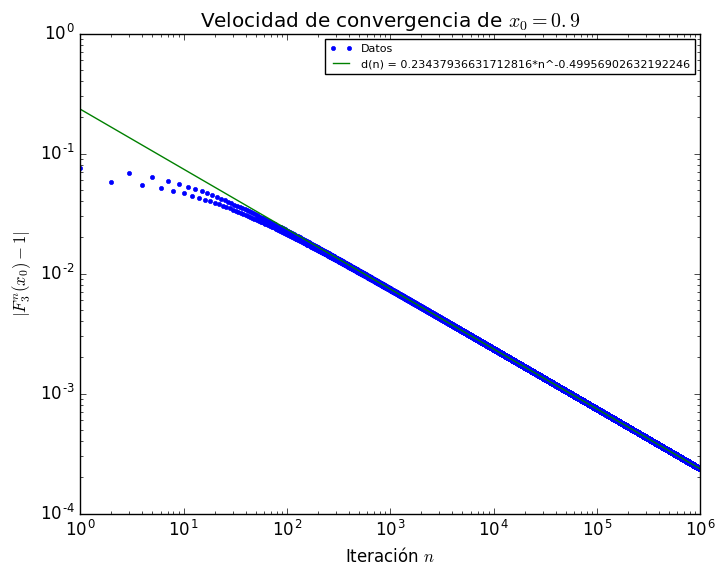

In [20]:
fit = curve_fit(model1, log(dom2), log(d2), [5.0, 5.0])
b2, a2 = fit.param
ran2 = Float64[exp(a2)*x^b2 for x in dom2]
loglog(d2, ".", label = "Datos")
loglog(dom2, ran2, label = "d(n) = $(exp(a2))*n^$b2")
legend(fontsize = 8, loc = "auto")
title(L"Velocidad de convergencia de $x_0 = 0.9$")
xlabel(L"Iteración $n$")
ylabel(L"|F_3^n(x_0) - 1|")
show()

**Ejercicio 1:**

Llamemos $c_n$ el valor del parámetro $c$ donde ocurre la bifurcación de doblamiento de periodo para el mapeo $Q_c(x)$, donde la órbita de periodo $2^n$ nace. Es decir, tenemos que $c_0=1/4$ marca la aparición del atractor de periodo $2^0=1$, $c_1=-1/4$ corresponde a la aparición del atractor de periodo $2^1=2$, $c_2=-3/4$ a la aparición del atractor de periodo $2^2=4$, etc. 

A partir de estos valores y otros que calcularán (al menos deben encontrar $c_6$), definimos la secuencia: $\{f_0, f_1, f_2, \dots\}$, donde

\begin{equation}
f_n = \frac{c_n-c_{n+1}}{c_{n+1}-c_{n+2}} .
\end{equation}

La pregunta es, ¿a qué valor converge esta secuencia?, es decir, dar una estimación de $f_\infty$.



*Hint:* Para realizar este ejercicio deben calcular el atractor para varias valores de $c$, de tal manera que puedan aislar las órbitas de periodo $2^p$ y de ahí determinar varios valores $c_n$. Sin embargo, van a requerir suficiente cuidado para obtener una buena aproximación de $c_n$. 

Una opción, que tiene ciertos inconvenientes numéricos que también ciertas ventajas se basa en recordar/usar que las bifurcaciones de doblamiento de periodo ocurren cuando los puntos de la órbita de periodo $p$ se tornan en repulsores, es decir, $(Q_c^p)'(x)=-1$. Esta opción, entonces, involucra obtener los valores $c_n$ usando los polinomios $Q_c^p(x)$ y diferenciación automática.

In [3]:
Qc(x,c) = x^2 + c
nombre(n::Int, c) = Symbol( string("Qc", n, c) )

function Qcs(n::Int, c, z)
    # Checo que `n` sea >= 1
    @assert n ≥ 1   # ≥ se obtiene con \ge<TAB>
    ex = :(x -> x^2 + $c)
    for i = 2:n
        ex = :(x -> $(ex)(x^2 + $c))
    end
    ex_ret = :($(nombre(n, z))(x) = $ex(x))
    return ex_ret
end

function calculacs!(p::Int, domc::FloatRange{Float64}, cs)
    fs = Function[]
    xd = xdual(0.0)
    count = 1
    for ci in domc
        x0 = 0.0
        expre1 = Qcs(p, ci, count)
        push!(fs, eval(expre1))
        x0 = puntofijo(fs[end], [-2, 2])
        if length(x0) > 0
            xd = xdual(x0[1])
            fxd = fs[end](xd)
            if abs(fxd.der - (1)) < 1e-5
                push!(cs, ci)
            end
        end
        count += 1
    end
    return nothing
end

calculacs! (generic function with 1 method)

In [4]:

k = (eval(Qcs(6,-1.36,4)))(1)-1
#a = Poly(jaja6)
#poly_rt = roots(a)

-2.1787367264382684

In [4]:
function real_rt(Qcs)
    
jaja(x) = Q(x)-x
a = Poly(jaja)
poly_rt = roots(a)
    root_vec = Float64[] 

for i in eachindex(poly_rt)
    if imag(poly_rt[i]) == 0.0
        push!(root_vec,poly_rt[i])
    end
end
root_vec
end


real_rt (generic function with 1 method)

In [5]:
function calculacs_poly!(p::Int, domc::FloatRange{Float64}, cs)
    fs = Function[]
    xd = xdual(0.0)
    count = 1
    
    for ci in domc   
        x0 = 0.0
        expre1 = Qcs(p, ci, count)
        push!(fs, eval(expre1))
        x0 = real_rt(fs[end])
       if length(x0) > 0
            xd = xdual(x0[1])
            fxd = fs[end](xd)
            if abs(fxd.der + 1) < 1e-5
                push!(cs, ci)
            end
        end
        count += 1
    end
    return nothing
end

calculacs_poly! (generic function with 1 method)

In [11]:
one(2)

1

In [ ]:
#Aquí hallamos c0
cs1 = Float64[]
crange = 0.25:-1/2^6:0
calculacs_poly!(1,crange, cs1)
cs1

ERROR (unhandled task failure): MethodError: no method matching show_backtrace(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::Symbol, ::Array{Ptr{Void},1}, ::UnitRange{Int64})
Closest candidates are:
  show_backtrace(::IO, !Matched::Array{Any,1}) at replutil.jl:578
  show_backtrace(::IO, !Matched::Array{T,1}) at replutil.jl:572


In [6]:
#Ahora seguimos con c1
crange = 0.0:-1/2^6:-1
calculacs!(2,crange, cs1)
cs1

2-element Array{Float64,1}:
  0.25
 -0.75

In [7]:
#Ahora seguimos con c2
crange = (-0.75-1/2^6):-1/2^6:-2
calculacs!(4,crange, cs1)
cs1

3-element Array{Float64,1}:
  0.25
 -0.75
 -1.25

In [ ]:
#Ahora seguimos con c3
crange = (-1.25-1/2^8):-1/2^8:-1.45
calculacs!_sofi(8,crange, cs1,[-1.45,2])
cs1

ERROR (unhandled task failure): MethodError: no method matching show_backtrace(::Base.AbstractIOBuffer{Array{UInt8,1}}, ::Symbol, ::Array{Ptr{Void},1}, ::UnitRange{Int64})
Closest candidates are:
  show_backtrace(::IO, !Matched::Array{Any,1}) at replutil.jl:578
  show_backtrace(::IO, !Matched::Array{T,1}) at replutil.jl:572


In [ ]:
#Ahora seguimos con c4
crange = (cs1[end]):-1/2^6:-2
calculacs!(16,crange, cs1)
cs1

In [ ]:
#Ahora seguimos con c5
crange = (cs1[end]):-1/2^6:-2
calculacs!(32,crange, cs1)
cs1

In [ ]:
#Ahora seguimos con c6
crange = (cs1[end]):-1/2^6:-2
calculacs!(64,crange, cs1)
cs1

Como lo implementé, necesito todas las funciones de Benet, y las tuyas. Creo que tu sabes cómo no usar el AuDiff de Benet, ahí lo checas.

In [2]:
workspace()

In [1]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. }
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    #xx
    nothing
end

"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        ff[:,ic] = xx
    end
    
    return ff
end



#Todo lo de AuDiff para que calcule la derivada 

type AuDiff{T<:Real} <: Real
    fun :: T
    der :: T
end
AuDiff(a, b) = AuDiff(promote(a,b)...)
AuDiff{T<:Real}(a::T) = AuDiff(a, zero(T))
import Base: convert

convert(::Type{AuDiff}, b::Real) = AuDiff(b)
convert{T<:Real, S<:Real}(::Type{AuDiff{T}}, b::S) = AuDiff(convert(T,b))
convert{T<:Real}(::Type{AuDiff{T}}, b::T) = AuDiff(b)
convert{T<:Real, S<:Real}(::Type{AuDiff{T}}, b::AuDiff{S}) = 
    AuDiff(convert(T,b.fun),convert(T,b.der))
import Base: promote_rule, promote

promote_rule{T<:Real}(::Type{AuDiff{T}}, ::Type{T}) = AuDiff{T}
promote_rule{T<:Real, S<:Real}(::Type{AuDiff{T}}, ::Type{S}) = AuDiff{promote_type(T, S)}
import Base: +, -, *, /, ^

+(a::AuDiff, b::AuDiff) = AuDiff(a.fun+b.fun, a.der+b.der)

-(a::AuDiff, b::AuDiff) = AuDiff(a.fun-b.fun, a.der-b.der)

*(a::AuDiff, b::AuDiff) = AuDiff(a.fun*b.fun, a.fun*b.der+a.der*b.fun)

function /(a::AuDiff, b::AuDiff)
    nn = a.fun/b.fun
    dd = (a.der - nn*b.der)/b.fun
    return AuDiff(nn, dd)
end

import Base: exp, log, sin, cos, tan

tup_fn   = [:exp, :log, :sin, :cos, :tan]
tup_fder = [:exp, :(x -> 1/x), :(x -> cos(x)), :(x -> -sin(x)), :(x -> (sec(x))^2)]

for (fn, fnder) in zip(tup_fn, tup_fder)
    @eval ($fn)(a::AuDiff) = AuDiff( ($fn)(a.fun), a.der*($fnder)(a.fun) )
end

#Tu función que crea polinomios

Qc(x,c) = x^2 + c
nombre(n::Int, c) = Symbol( string("Qc", n, c) )
function Qcs(n::Int, c, z)
    # Checo que `n` sea >= 1
    @assert n ≥ 1   # ≥ se obtiene con \ge<TAB>
    ex = :(x -> x^2 + $c)
    for i = 2:n
        ex = :(x -> $(ex)(x^2 + $c))
    end
    ex_ret = :($(nombre(n, z))(x) = $ex(x))
    return eval(ex_ret)
end





  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31


Qcs (generic function with 1 method)

  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
in display_dict at /home/sof9409/.julia/v0.3/IJulia/src/execute_request.jl


Ok, aquí va la función

In [2]:
"""
puntosbifurc(f, nit, nout, crange,p,tol)

Itera el mapeo `f(x,c)` `nit+nout` veces en un rango de c en `crange`. 
Calcula `f(x,c)` de orden `p` en cada c del rango. Obtiene el valor de la derivada de cada  `f(x,c)`
para las últimas `nout` iteraciones. 

Cuando la derivada es tan cercana a -1 como lo permite `tol`, guarda la c presente y la cercanía.
"""
function puntosbifurc(f, nit, nout, crange,p,tol) #combiné lo que tenía Benet con lo tuyo.
    xx = Vector{Float64}(nout)
    ff = Any[]
    fs = Function[]
    count = 1
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c) #para cada c en el rango saca las últimas 'nout' iteraciones 
                                            # y las coloca en xx
        
        expre1 = Qcs(p, c, count) 
        push!(fs, eval(expre1)) #lo mismo que tenías, hace el polinomio de grado p para cada c y las guarda en fs
        
        for i in 1:nout
            near  = abs((fs[end](AuDiff(xx[i],1)).der)+1) 
            #el último polinomio de fs corresponde al de c presente. Al operar sobre el AuDiff de Benet para cada xx[i]
            #saca el valor de la función en los puntos de convergencia y cuánto vale la derivada ahí. 
            #por cierto, sí es -1, entonces le +1, saco abs y comparo con la toleracia
            if near < tol
                push!(ff,[c,near,fs[end](AuDiff(xx[i],1)).der]) #si < que la toleracia,guarda en ff la c con que se trabajó y qué tan cercano fue
            end
        end
        count += 1 
    end
    
    return ff
end

In [3]:
#c1
Qc(x,c) = x^2 + c

crange = -0.74:-1/2^15:-0.76
xx = puntosbifurc(Qc, 1000, 100, crange,1,4E-6)


3-element Array{Any,1}:
 [-0.746622,3.68077e-6,-1.0]     
 [-0.746683,3.498e-6,-1.0]       
 [-0.746714,3.89467e-6,-0.999996]

  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
  likely near /home/sof9409/.julia/v0.3/IJulia/src/kernel.jl:31
in display_dict at /home/sof9409/.julia/v0.3/IJulia/src/execute_request.jl


In [4]:
##### c2
crange = -1.24:-1/2^15:-1.26
xx = puntosbifurc(Qc, 1000, 50, crange,2,2E-6)

1-element Array{Any,1}:
 [-1.24851,1.6853e-6,-1.0]

In [5]:
#c3
crange = -1.36:-1/2^15:-1.37
xx = puntosbifurc(Qc, 1000, 50, crange,3,6E-5)

1-element Array{Any,1}:
 [-1.36769,5.41086e-5,-0.999946]

In [6]:
#c4
crange = -1.36:-1/2^15:-1.405
xx = puntosbifurc(Qc, 1000, 50, crange,4,0.0001)

1-element Array{Any,1}:
 [-1.36751,4.20698e-5,-0.999958]

In [ ]:
#c5
crange = -1.36:-1/2^16:-1.405
xx = puntosbifurc(Qc, 2000, 50, crange,4,0.0001)

In [5]:
#c5
crange = -1.36:-1/2^15:-1.405
xx = puntosbifurc(Qc, 1000, 50, crange,6,0.0001)

0-element Array{Any,1}

In [ ]:
a = 4.67
a_2 = 0.25
a_1 = -0.75
(1+1/a)*a_1 - (1/a)*a_2

**Ejercicio 2:**

Repitan el ejercicio anterior para el mapeo $S_c(x) = c \sin(x)$. ¿Cómo se comparan los valores obtenidos de $f_n$?

**Ejercicio 3:**

Como se ve en la Fig. 1 (de [este](https://github.com/lbenet/2017-1_TSFisComp/blob/master/notas_clase/08_Mapeos1d-3.ipynb) notebook), $x=0$ pertenece a un ciclo de periodo $2^n$ para ciertos valores $C_n$ del parámetro. Dichos valores son *especiales*, ya que $x=0$ esté en el ciclo de periodo $2^n$ marca los llamados *ciclos superestable*, donde tenemos $(Q^{2^p}_{C_n})'(0)=0$.

¿A qué converge la secuencia $f_n$, definida ahora con los valores $C_n$.

De los $2^p$ puntos del ciclo de periodo $2^p$, es decir, $\{0, p_1, \dots p_{2^{n-1}}\,\}$ hay uno (distinto del 0) cuya distancia a 0 es menor; a ese punto lo identificamos como $d_n$. Calcular numéricamente a dónde converge la secuencia $d_n/d_{n+1}$.

In [ ]:
func = Function[x+1,x+3]